In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from PIL import Image
from wordcloud import WordCloud
from nrclex import NRCLex #detect more emotions
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Uncomment for first use
# nltk.download('punkt')
# nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
sns.set_style("whitegrid")

In [2]:
df=pd.read_csv('../data/train.csv')

# Basic Data Overview

In this project we are using Disaster Tweets dataset from Kaggle to determine whether a given tweet informs about a real disaster or is a fake info. 

We have 5 columns:
* **id** : unique tweet id
* **keword** : extracted keyword from a given tweet
* **location** : location from which tweet was sent
* **text** : text of a tweet
* **target** : 0-1 value indicating whether a tweet is fake(0) or real (1)

In [3]:
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
df.shape

(7613, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df['keyword'].nunique()

221

In [7]:
df['location'].nunique()

3341

**First observations**
* We have 5 columns and 7613 rows
* We have some missing values in location and keyword column
* We have 221 unique keywords and more than 3000 unique locations
* Locations for the same place are written in different format in some rows

# EDA and Feature Engineering

**1. Target Analysis**

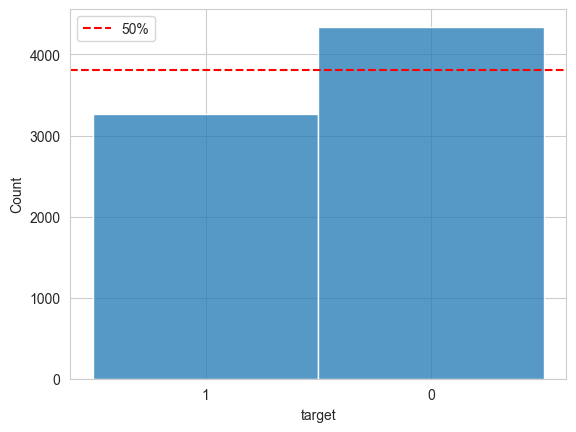

In [8]:
sns.histplot(df['target'].astype(str))
fifty_percent_count = len(df) / 2
plt.axhline(y=fifty_percent_count, color='red', linestyle='--', label='50%')
plt.legend()
plt.show()

In [9]:
target_percentage = df['target'].value_counts(normalize=True) * 100
percentage_table = pd.DataFrame({'Target': target_percentage.index, 'Percentage': target_percentage.values})
percentage_table

,Target,Percentage
0,0,57.034021
1,1,42.965979


There is a slight class imbalance - there are more false tweets

**2. Number of words in caps lock vs target**

In [10]:
def count_caps_lock(text):
    words = text.split()
    caps_lock_words = [word for word in words if word.isupper()]
    return len(caps_lock_words)

In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
df['Caps_lock_word_count'] = df['text'].apply(count_caps_lock)
df[['text','Caps_lock_word_count']].head(10)

,text,Caps_lock_word_count
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,0
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0
3,"13,000 people receive #wildfires evacuation orders in California",0
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,0
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",0
7,I'm on top of the hill and I can see a fire in the woods...,1
8,There's an emergency evacuation happening now in the building across the street,0
9,I'm afraid that the tornado is coming to our area...,0


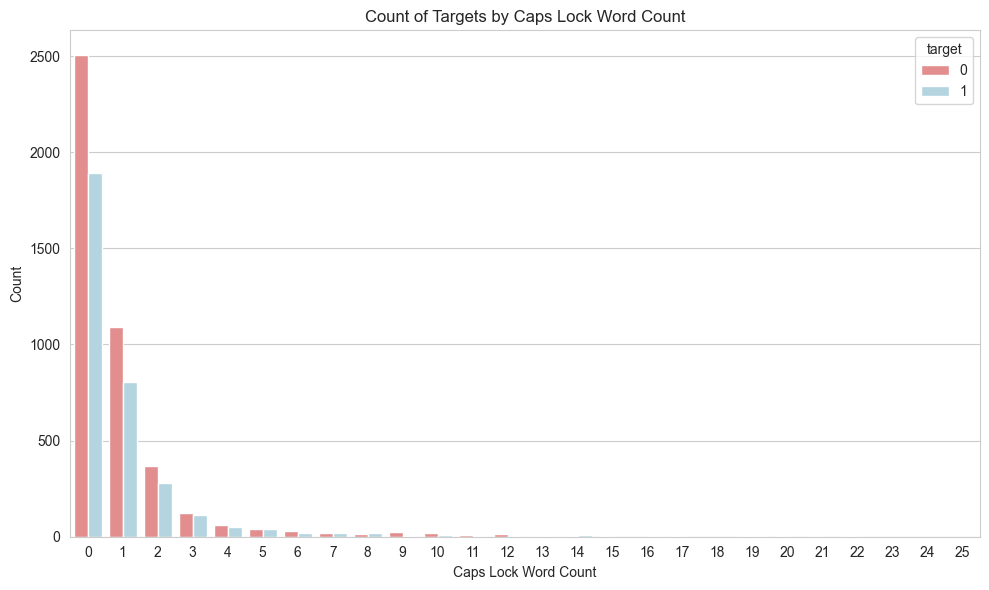

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Caps_lock_word_count', hue='target', palette=['lightcoral', 'lightblue'])
plt.xlabel('Caps Lock Word Count')
plt.ylabel('Count')
plt.title('Count of Targets by Caps Lock Word Count')
plt.tight_layout()
plt.show()

We can see that the majority of tweets don't have many words in caps lock. However we can see that the percentage of true tweets increases with the increase of caps lock words - more than 4 caps lock words have 50/50 false and true tweets

**3. Number of '!' vs target**

In [14]:
def count_exclamation_mark(text):
    return len(re.findall(r'!', text))

In [15]:
df['Number_of_exclamation'] = df['text'].apply(count_exclamation_mark)
df.head(10)

,id,keyword,location,text,target,Caps_lock_word_count,Number_of_exclamation
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,0
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,0,0
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,0,0
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1,1,0
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1,0,0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1,0,0


<Axes: xlabel='Number_of_exclamation', ylabel='count'>

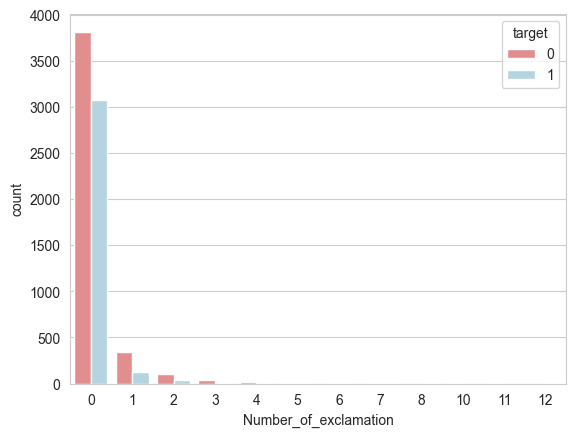

In [16]:
sns.countplot(df,x='Number_of_exclamation', hue='target',palette=['lightcoral', 'lightblue'])

In [17]:
pd.crosstab(df['Number_of_exclamation'], df['target'], normalize='index')*100

target,0,1
Number_of_exclamation,,
0,55.395997,44.604003
1,72.594142,27.405858
2,72.727273,27.272727
3,78.846154,21.153846
4,80.000000,20.000000
5,50.000000,50.000000
6,71.428571,28.571429
7,66.666667,33.333333
8,0.000000,100.000000


There is no obvious pattern, most tweets have 0,1,2 exclamation marks

In most groups there are more fake tweets

**4. Number of # vs target**

In [18]:
def count_hashtags(text):
    return len(re.findall(r'#\w+', text))

In [19]:
df['Number_of_hashtags']= df['text'].apply(count_hashtags)

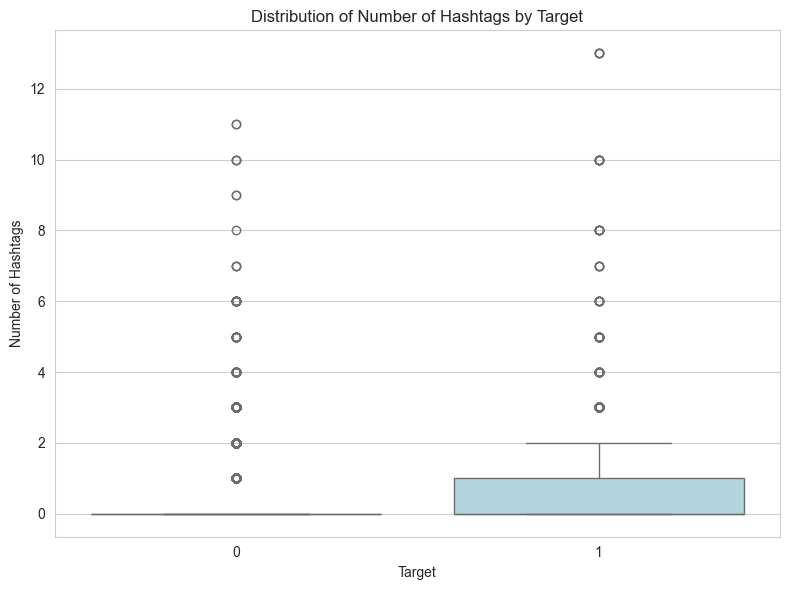

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='target', y='Number_of_hashtags', hue='target', palette=['lightcoral', 'lightblue'], dodge=False)
plt.legend().remove()
plt.xlabel('Target')
plt.ylabel('Number of Hashtags')
plt.title('Distribution of Number of Hashtags by Target')
plt.tight_layout()
plt.show()

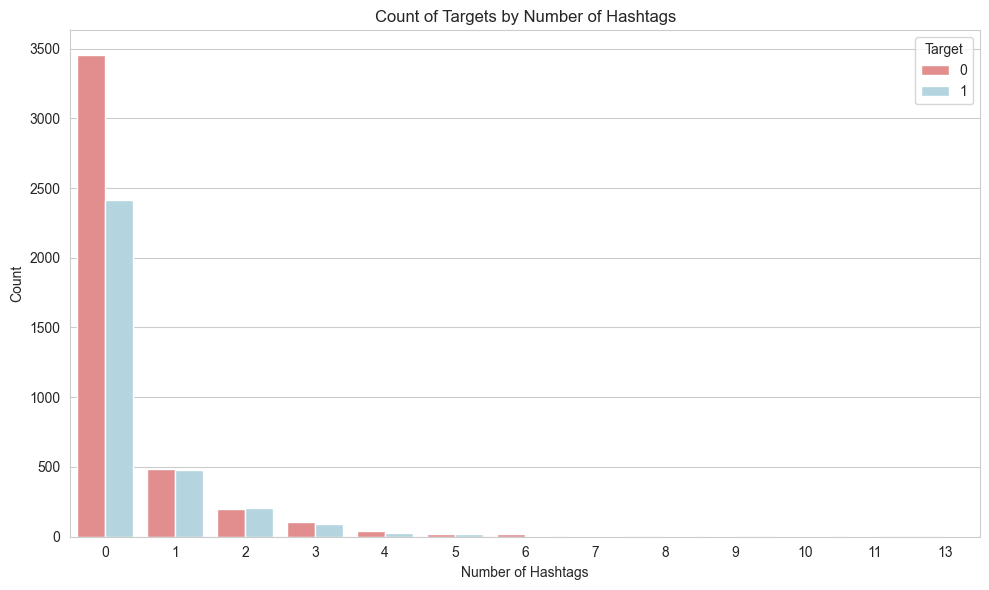

In [21]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Number_of_hashtags', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Number of Hashtags')
plt.xlabel('Number of Hashtags')
plt.ylabel('Count')
plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

The majority of tweets have 0 hashtags. For 1,2,3 hashtags there are circa 50/50 false and true tweets. If there is no hashtags the tweet is more likely to be false

**5. Number of words vs target**

In [22]:
def count_words(text):
    return len(text.split())

In [23]:
df['Word_count'] = df['text'].apply(count_words)

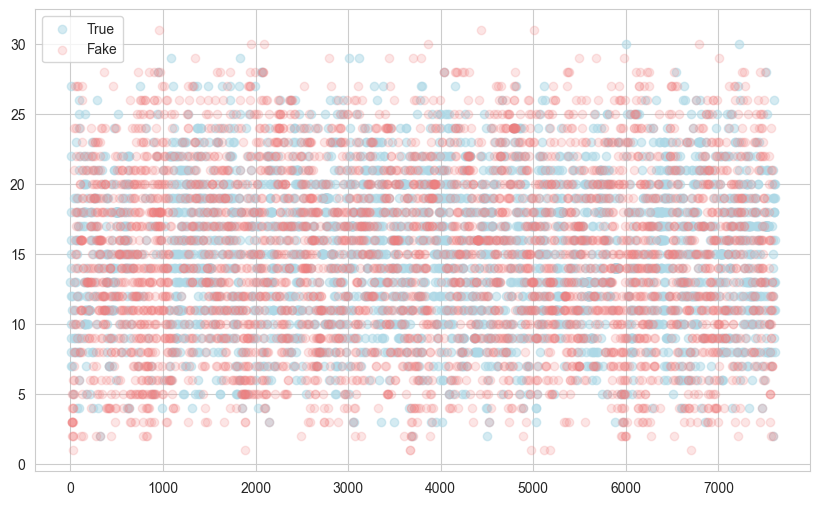

In [24]:
true = df[df['target']==1]
false = df[df['target']==0]

plt.figure(figsize=(10,6))
plt.scatter(true.index, true['Word_count'], label='True', color='lightblue',alpha=0.5)
plt.scatter(false.index, false['Word_count'], label='Fake', color='lightcoral',alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()

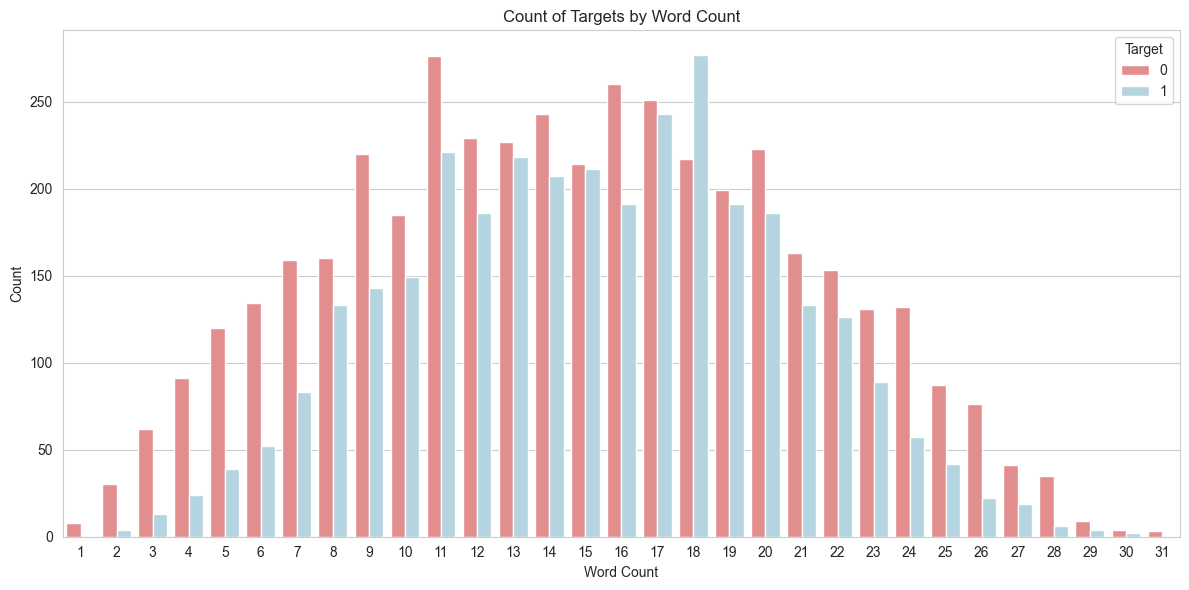

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Word_count', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Word Count')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

* there is no visible pattern between number of words and target
* We can only see that if the tweet is very short (1-10 words) or very long (>30 words) it is probably fake
* looks like normal distribution

**6. Punctuation vs target**

In [26]:
def count_punctuation(text):
    punctuation_pattern = r'[^\w\s]'
    punct = re.findall(punctuation_pattern, text)
    return len(punct)

In [27]:
df['Punctuation_count'] = df['text'].apply(count_punctuation)

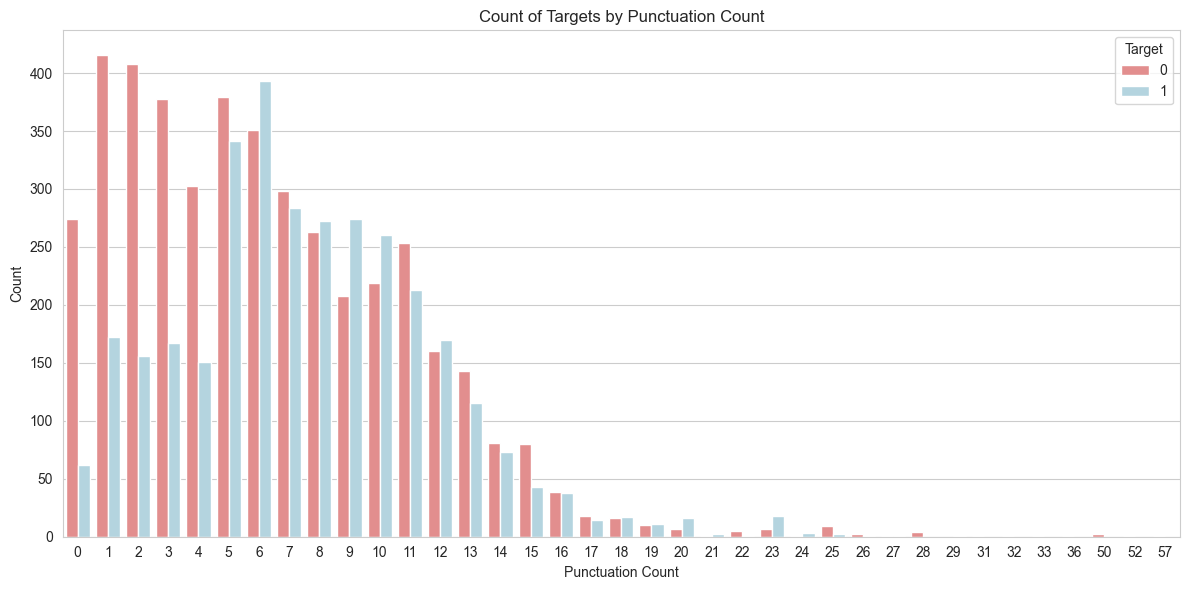

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Punctuation_count', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Punctuation Count')
plt.xlabel('Punctuation Count')
plt.ylabel('Count')
plt.legend(title='Target')
plt.tight_layout()
plt.show()

* we can see a visible pattern : tweets with little punctuation tend to be fake, and tweets with 6-11 punctuation signs are more likely to be true

**7. Number of links vs target**

In [29]:
def count_links(text):
    url_pattern = r'https?://\S+|www\.\S+'
    links=re.findall(url_pattern,text)
    return len(links)

In [30]:
df['Link_count']=df['text'].apply(count_links)

<Axes: xlabel='Link_count', ylabel='count'>

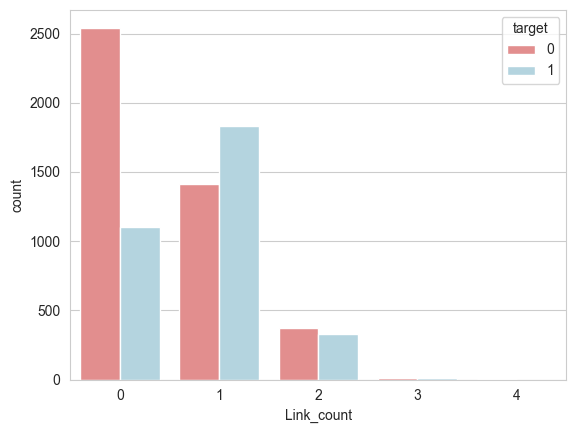

In [31]:
sns.countplot(df, x='Link_count', hue='target',palette=['lightcoral', 'lightblue'])

In [32]:
pd.crosstab(df['Link_count'], df['target'], normalize='index')*100

target,0,1
Link_count,,
0,69.824272,30.175728
1,43.517093,56.482907
2,52.932761,47.067239
3,59.090909,40.909091
4,100.000000,0.000000


**8. Number of stopwords vs target**

In [33]:
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))
    sw = [word for word in text.split() if word in stop_words]
    return len(sw)

In [34]:
df['Stopword_count']=df['text'].apply(count_stopwords)

<Axes: xlabel='Stopword_count', ylabel='count'>

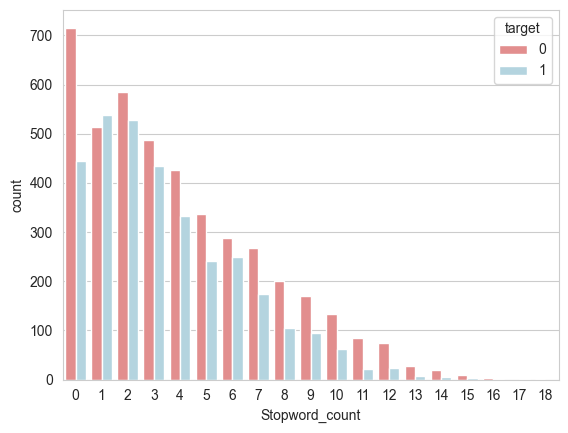

In [35]:
sns.countplot(df, x='Stopword_count', hue='target', palette=['lightcoral', 'lightblue'])

In [36]:
pd.crosstab(df['Stopword_count'],df['target'],normalize='index')*100

target,0,1
Stopword_count,,
0,61.724138,38.275862
1,48.812915,51.187085
2,52.565257,47.434743
3,52.819957,47.180043
4,56.126482,43.873518
5,58.304498,41.695502
6,53.445065,46.554935
7,60.407240,39.592760
8,65.901639,34.098361


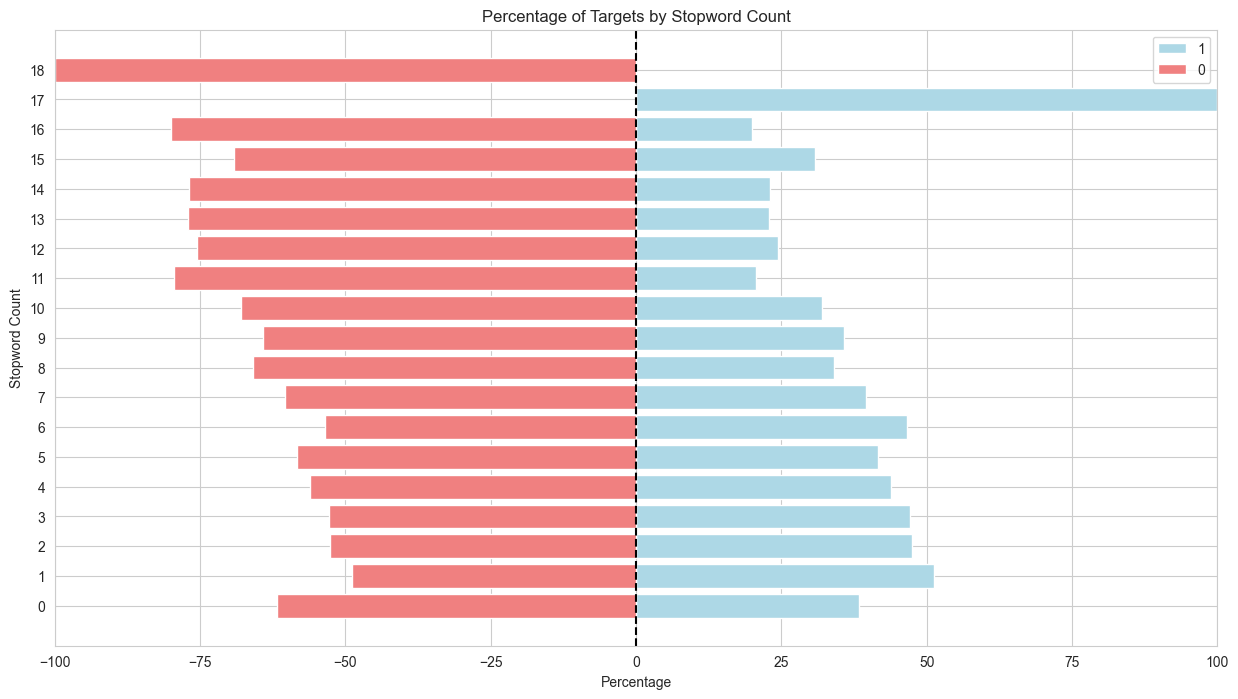

In [37]:
crosstab_normalized = pd.crosstab(df['Stopword_count'], df['target'], normalize='index') * 100

plt.figure(figsize=(15, 8))
legend_added = False
for index, row in crosstab_normalized.iterrows():
    plt.barh(
        str(index),
        row[1],
        color="lightblue",
        label="1" if not legend_added else "",
    )
    plt.barh(
        str(index),
        -row[0],
        color="lightcoral",
        label="0" if not legend_added else "",
    )
    if not legend_added:
        legend_added = True
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percentage")
plt.ylabel("Stopword Count")
plt.title("Percentage of Targets by Stopword Count")
plt.xlim(-100, 100)
plt.legend(loc="upper right")
plt.show()

* The percent of fake tweets is slightly higer when there are more stop words

**9. Number of mentions vs target**

In [38]:
def count_mentions(text):
    mention_pattern = r'@\w+'
    mentions=re.findall(mention_pattern,text)
    return len(mentions)
df['Mentions_count']=df['text'].apply(count_mentions)

<Axes: xlabel='Mentions_count', ylabel='count'>

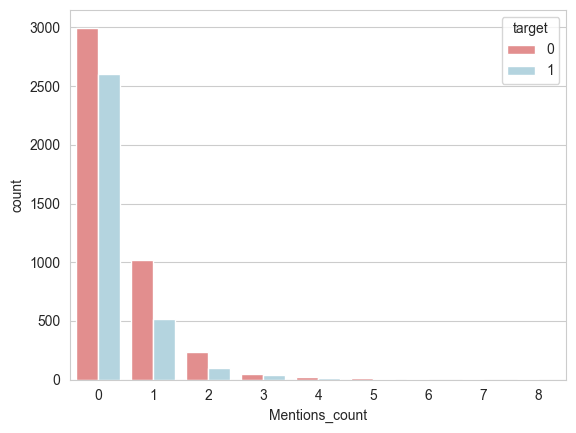

In [39]:
sns.countplot(df, x='Mentions_count', hue='target', palette=['lightcoral', 'lightblue'])

**10. Parts of speech vs target**

In [40]:
def count_parts_of_speech(text, tag):
    tokens= word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    part_count = sum(1 for word,pos in tagged if pos.startswith(tag))
    return part_count

In [41]:
df['Verb_count'] = df['text'].apply(count_parts_of_speech, tag='V')
df['Noun_count'] = df['text'].apply(count_parts_of_speech, tag='N')
df['Adjective_count'] = df['text'].apply(count_parts_of_speech, tag='J')
df['Adverb_count'] = df['text'].apply(count_parts_of_speech, tag='R')

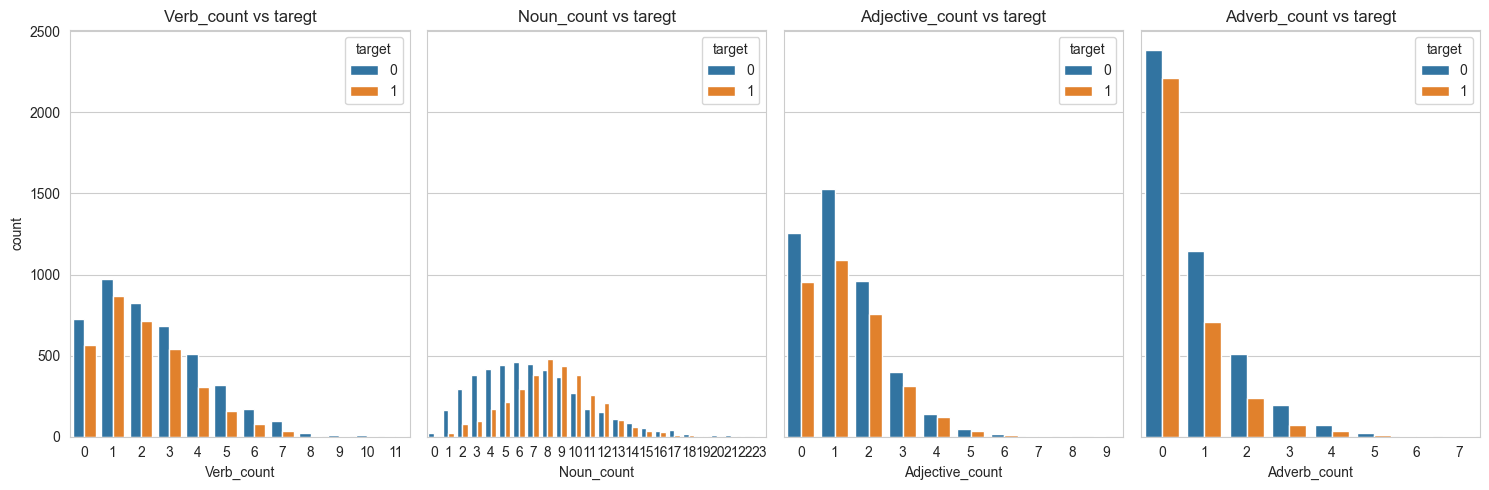

In [42]:
fig, axes = plt.subplots(1,4, figsize =(15,5), sharey=True)
parts = ['Verb_count', 'Noun_count', 'Adjective_count','Adverb_count']

for i,part in enumerate(parts):
    sns.countplot(data=df, x=part, hue='target', ax=axes[i])
    axes[i].set_title(f'{part} vs taregt')

plt.tight_layout()
plt.show()

* for verbs and adverbs there is a right-skewed count distribution for fake and true tweets
* We can see a visible pattern in Noun count : Fake tweets have less nouns that true ones

**Feature correlation**

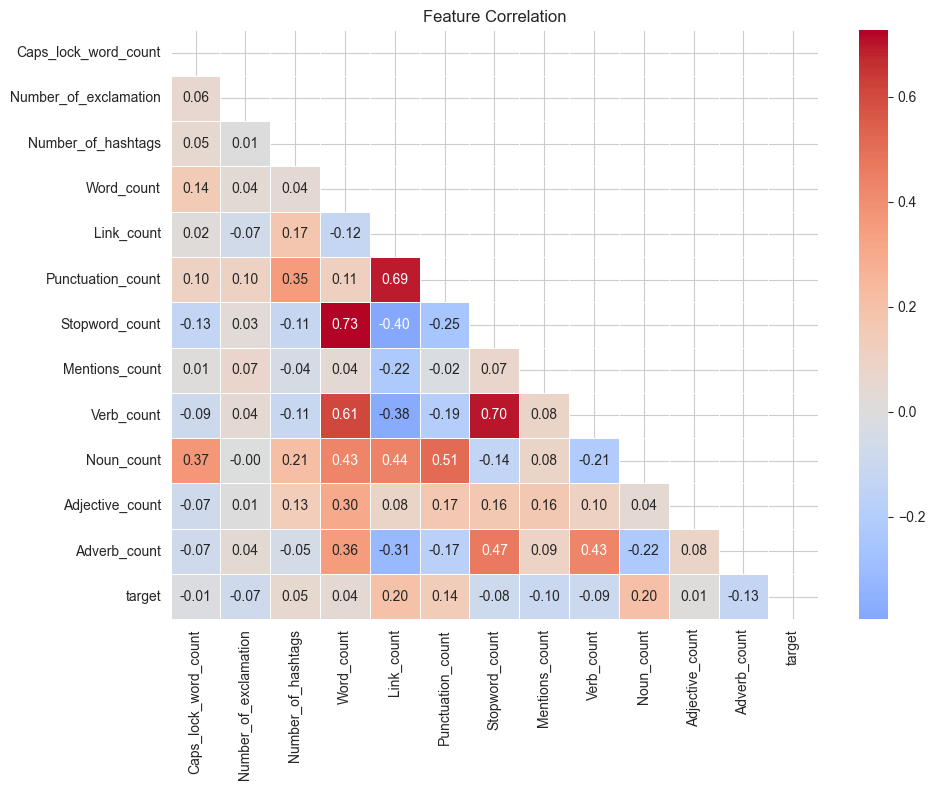

In [43]:
columns = ['Caps_lock_word_count', 'Number_of_exclamation', 'Number_of_hashtags', 
           'Word_count', 'Link_count', 'Punctuation_count', 'Stopword_count','Mentions_count','Verb_count','Noun_count','Adjective_count','Adverb_count', 'target']
correlation_matrix = df[columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, mask=mask, center=0)
plt.title('Feature Correlation')
plt.tight_layout()
plt.show()

We can see that new column like link_count, noun_count ,punctuation_count and adverb_count have the biggest correlation with the target

**Keywords vs target**

In [44]:
missing_keywords = len(df[df['keyword'].isna()])
missing_keywords

61

We have 61 missing keywords( maybe we will fill them in later)

In [45]:
only_missing_keywords = df[df['keyword'].isna()]
print("Percent of true emergencies where the keyword is missing:")
percent = len(only_missing_keywords[only_missing_keywords['target']==1])/missing_keywords
print((round(percent,2)*100), "%")

Percent of true emergencies where the keyword is missing:
69.0 %


The majority of tweets with missing keyword are about true disasters

In [46]:
top_keywords = df['keyword'].value_counts().head(20) # extraxting top found keywords
top_keywords

keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: count, dtype: int64

In [47]:
print("{:<15} {:<15} {:<10} {:<10}".format('Keyword', 'Occurrences', 'True %', 'False %')) # analyse keword vs true or false tweet
print('\n')
for keyword,count in top_keywords.items():
    true = df[df['keyword']==keyword]['target'].mean()*100
    false = 100-true
    print("{:<15} {:<15} {:<10.2f} {:<10.2f}".format(keyword, count, true, false))


Keyword         Occurrences     True %     False %   


fatalities      45              57.78      42.22     
deluge          42              14.29      85.71     
armageddon      42              11.90      88.10     
sinking         41              19.51      80.49     
damage          41              46.34      53.66     
harm            41              9.76       90.24     
body%20bags     41              2.44       97.56     
outbreak        40              97.50      2.50      
evacuate        40              62.50      37.50     
fear            40              12.50      87.50     
collided        40              57.50      42.50     
siren           40              12.50      87.50     
twister         40              12.50      87.50     
windstorm       40              40.00      60.00     
sinkhole        39              69.23      30.77     
sunk            39              23.08      76.92     
hellfire        39              17.95      82.05     
weapon          39        

* We can see that words like: fatalities,outbreak, evacuate, sinkhole, famine are more likely to occure in true tweets whereas deluge, armageddon, sinking, harm, fear, siren ... are often used in fake tweets

**Location vs target**

In [48]:
print("Percent of tweets with missing location:", round(len(df[df['location'].isna()])*100/len(df),2),"%")

Percent of tweets with missing location: 33.27 %


In [49]:
top_locations = df['location'].value_counts().head(30) # let's extraxt top found locations
top_locations

location
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Australia            18
Chicago, IL          18
California           17
Everywhere           15
New York, NY         15
California, USA      15
Florida              14
San Francisco        14
United Kingdom       14
Los Angeles          13
Indonesia            13
Washington, D.C.     13
Toronto              12
NYC                  12
Ireland              12
Seattle              11
Earth                11
Name: count, dtype: int64

Locations are redundant : there are values like USA, United States, New York and New York,NY 

In [50]:
df['location'].nunique()

3341

In [51]:
# mapping values from the most frequent locations to their countries (pewnie jest jakis lepszy sposób na to )
def map_countries(location):
    if location in ['New York','United States','Los Angeles, CA','NYC','Los Angeles','Washington, DC','San Francisco','California, USA','Florida','New York, NY', 'California']:
        return 'USA'
    elif location in ['London', 'UK','England.', 'London, UK']:
        return 'UK'
    else:
        return location
df['Location_grouped'] = df['location'].apply(map_countries)  

In [52]:
top_locations_grouped = df['Location_grouped'].value_counts().head(10)
top_locations_grouped

Location_grouped
USA            372
UK              83
Canada          29
Nigeria         28
India           24
Mumbai          22
Kenya           20
Worldwide       19
Chicago, IL     18
Australia       18
Name: count, dtype: int64

* The majority of tweets is from USA

**Sentiment analysis**

Every sentence can have a different emotional background. Some tweets can be written in positive, happy, negavite, angry or scared way. In this part we will analyse positive and negative sentiment as well as subjectivity. Then we will move on to extracting more emotions like fear, anger, joy etc

In [53]:

def get_polarity(text): # checking if a tweet was negative (-1), neutral (0) or positive (1)
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text): #checking if a tweet is subjective or objective
    return TextBlob(text).sentiment.subjectivity

df['polarity_score'] = df['text'].apply(get_polarity)
df['subjectivity_score'] = df['text'].apply(get_subjectivity)

Text(0.5, 1.0, 'Subjectivity vs target')

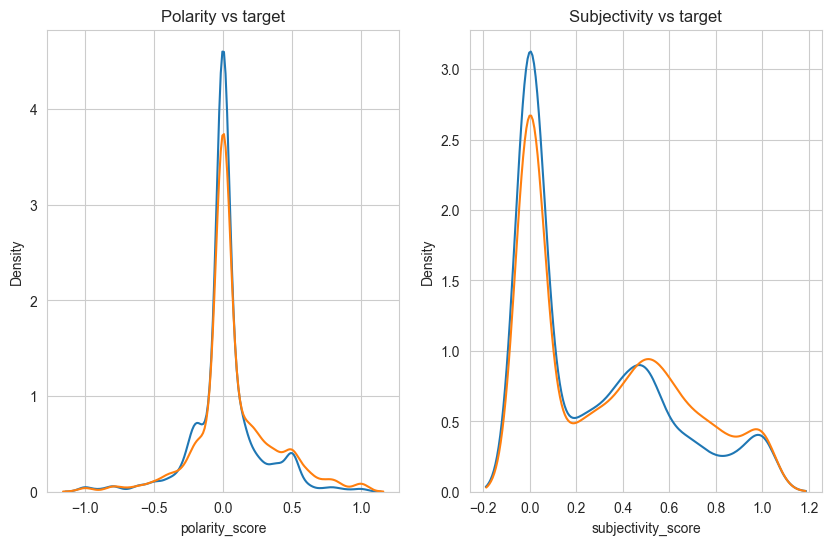

In [54]:
fig, axes = plt.subplots(1,2, figsize=(10,6))
true_tweets = df[df['target']==1]
false_tweets = df[df['target']==0]
sns.kdeplot(data=true_tweets['polarity_score'],  ax=axes[0])
sns.kdeplot(data=false_tweets['polarity_score'], ax=axes[0])
sns.kdeplot(data=true_tweets['subjectivity_score'],  ax=axes[1])
sns.kdeplot(data=false_tweets['subjectivity_score'], ax=axes[1])
axes[0].set_title("Polarity vs target")
axes[1].set_title("Subjectivity vs target")


Most tweets are neutral (not positive/negative) as well as objective (subjectivity=0)

In [55]:
def find_emotion(text):
    emotion = NRCLex(text)
    top = emotion.top_emotions
    emotion_names = [emotion_tuple[0] for emotion_tuple in top]
    return list(emotion_names)

df['Lead_emotions'] = df['text'].apply(find_emotion)
df.head(5)

,id,keyword,location,text,target,Caps_lock_word_count,Number_of_exclamation,Number_of_hashtags,Word_count,Punctuation_count,...,Stopword_count,Mentions_count,Verb_count,Noun_count,Adjective_count,Adverb_count,Location_grouped,polarity_score,subjectivity_score,Lead_emotions
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,1,0,1,13,1,...,5,0,1,6,0,0,NaN,0.00000,0.0000,"[fear, anger, surprise, negative, sadness]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,7,1,...,0,0,0,6,0,0,NaN,0.10000,0.4000,[fear]
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0,0,0,22,3,...,9,0,7,7,1,0,NaN,-0.01875,0.3875,"[trust, positive, negative, anticipation]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,0,1,8,2,...,1,0,1,4,1,0,NaN,0.00000,0.0000,[negative]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,0,2,16,2,...,6,0,3,6,0,1,NaN,0.00000,0.0000,[trust]


# Data preprocessing

In order to make a text more convenient for our model we will take on some preprocessing steps like:
* convert text to lower case
* delete punctuation 
* remove https links
* remove stopwords (a, the, an ...)
* tokenise text - extract single words from a text
* lemmatization - bring the extracted word to it's base form. For example 'running'->run 

In [56]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'@\w+', '', text) # remove mentions
    text = re.sub(r'\[.*?\]', '', text) # remove [] and things inside it 
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove links 
    text = re.sub(r'<.*?>+', '', text) # remove HTML tags
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    text = re.sub('\n', '', text) # remove newline
    text = re.sub(r'\w*\d\w*', '', text) # remove digits
    
    return text

In [57]:
lemmatizer = WordNetLemmatizer()

# tagging words
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'  # Adjective
    elif nltk_tag.startswith('V'):
        return 'v'  # Verb
    elif nltk_tag.startswith('N'):
        return 'n'  # Noun
    elif nltk_tag.startswith('R'):
        return 'r'  # Adverb
    else:          
        return None

# lemmatization with POS tagging 
def lemmatize_sentence(sentence):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence

In [58]:
# removing stop words
stop_words = set(stopwords.words('english'))
def filter_stop_words(tokenized_tweet):
    return [word for word in tokenized_tweet if word not in stop_words]

# processing text 
def processing_text(text): 
    text = clean_text(text)
    lematized = lemmatize_sentence(text)
    without_stopwords = filter_stop_words(lematized)
    return without_stopwords

In [59]:
df['cleaned_tokens'] = df['text'].apply(processing_text)
df.head(5)

,id,keyword,location,text,target,Caps_lock_word_count,Number_of_exclamation,Number_of_hashtags,Word_count,Punctuation_count,...,Mentions_count,Verb_count,Noun_count,Adjective_count,Adverb_count,Location_grouped,polarity_score,subjectivity_score,Lead_emotions,cleaned_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,1,0,1,13,1,...,0,1,6,0,0,NaN,0.00000,0.0000,"[fear, anger, surprise, negative, sadness]","[deed, reason, earthquake, may, allah, forgive, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,7,1,...,0,0,6,0,0,NaN,0.10000,0.4000,[fear],"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0,0,0,22,3,...,0,7,7,1,0,NaN,-0.01875,0.3875,"[trust, positive, negative, anticipation]","[resident, ask, shelter, place, notify, officer, evacuation, shelter, place, order, expect]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,0,1,8,2,...,0,1,4,1,0,NaN,0.00000,0.0000,[negative],"[people, receive, wildfire, evacuation, order, california]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,0,2,16,2,...,0,3,6,0,1,NaN,0.00000,0.0000,[trust],"[get, send, photo, ruby, alaska, smoke, wildfire, pour, school]"


# Visualizing Tokens

(-0.5, 999.5, 807.5, -0.5)

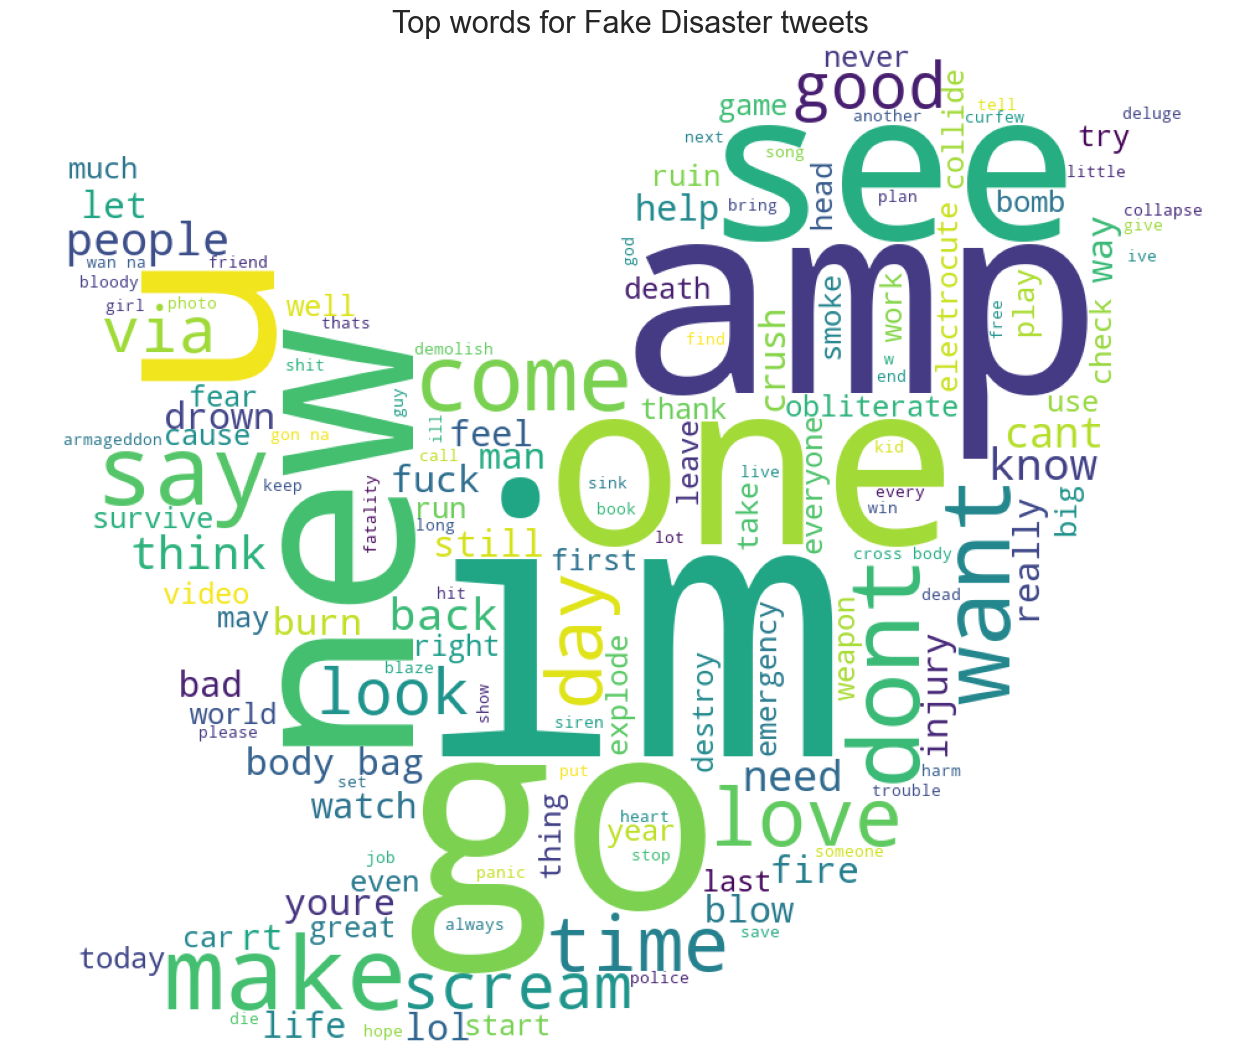

In [62]:
all_words = []
twitter_mask = np.array(Image.open('../img/twitter_mask2.jpg'))
for val in df.loc[df['target'] == 0, 'cleaned_tokens']:
     
    all_words.extend(val)

def sentence_maker(words):
    return " ".join(words)
    
all_words = sentence_maker(all_words)

wordcloud = WordCloud(width = 1400, height = 1400,
                background_color ='white',
                min_font_size = 10,
                mask = twitter_mask,
                collocations=True,
                max_words=150).generate(all_words)
plt.figure(figsize = (16, 16), facecolor = None)
plt.title('Top words for Fake Disaster tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wordcloud)
plt.axis("off")


(-0.5, 999.5, 807.5, -0.5)

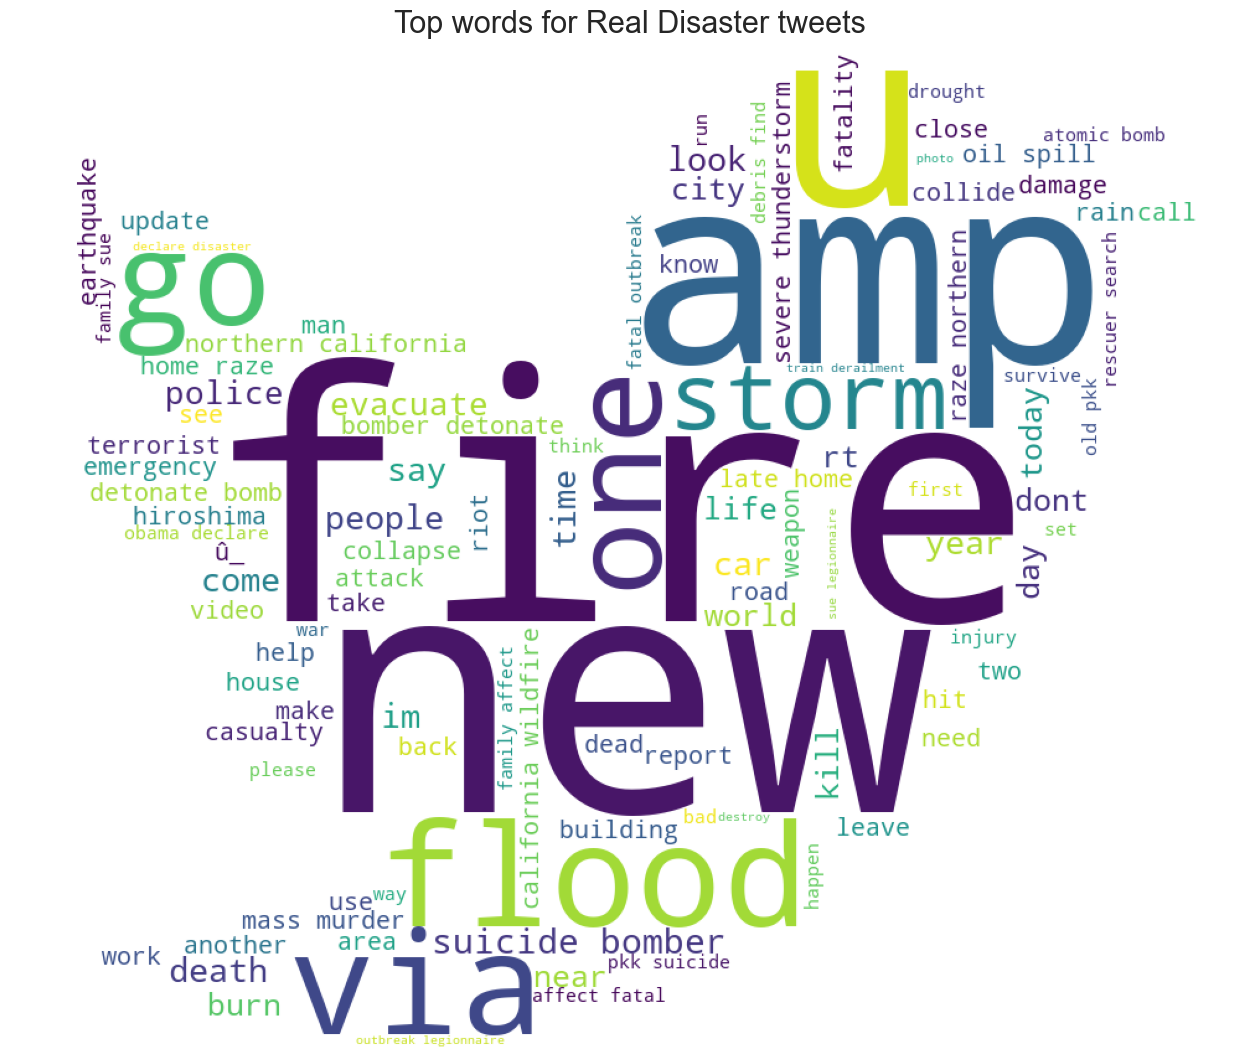

In [63]:
all_words = []
for val in df.loc[df['target'] == 1, 'cleaned_tokens']:
     
    all_words.extend(val)

def sentence_maker(words):
    return " ".join(words)
    
all_words = sentence_maker(all_words)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                mask = twitter_mask,
                collocations=True,
                max_words=200).generate(all_words)
plt.figure(figsize = (16, 16), facecolor = None)
plt.title('Top words for Real Disaster tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wordcloud)
plt.axis("off")

# Vectorization

In [64]:
df['clean_text'] = df['cleaned_tokens'].apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
clf = MultinomialNB()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.7951411687458962
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       874
           1       0.78      0.73      0.75       649

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.80      0.79      1523



In [66]:
# Calculate feature importance
feature_names = vectorizer.get_feature_names_out()
feature_log_prob = clf.feature_log_prob_

# Feature importance for each class
# Here we use the absolute value of log probabilities for simplicity
feature_importance = np.abs(feature_log_prob)

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame(feature_importance.T, index=feature_names, columns=clf.classes_)

# Display the top features for each class
print("Top features for True class:")
print(importance_df[1].sort_values(ascending=False).head(10))

print("Top features for False class:")
print(importance_df[0].sort_values(ascending=False).head(10))

Top features for True class:
__                10.501857
minus             10.501857
missile           10.501857
mislead           10.501857
misha             10.501857
misguided         10.501857
misfortunebut     10.501857
misfit            10.501857
miscalculation    10.501857
mirror            10.501857
Name: 1, dtype: float64
Top features for False class:
encourage          10.6284
ol                 10.6284
shanghai           10.6284
elvia              10.6284
shanghaiûªs        10.6284
kasabwe            10.6284
kashmir            10.6284
kashmirconflict    10.6284
olap               10.6284
shaper             10.6284
Name: 0, dtype: float64


In [67]:
# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1, 5, 10],
    'fit_prior': [True, False]
}

# Initialize the MultinomialNB classifier
clf = MultinomialNB()

# Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Perform grid search and fit to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the best model with the entire training data
best_clf = grid_search.best_estimator_

# Make predictions
y_pred = best_clf.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Best Parameters: {'alpha': 5, 'fit_prior': True}
Accuracy: 0.7951411687458962
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       874
           1       0.79      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.80      0.79      1523

